###  Importation des packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from scipy import stats

## 1. Preprocess on Train Data
 - SalePrice Distribution
 - Duplicate
 - Outliers

In [7]:
#import data
train = pd.read_csv('train.csv')
train.shape

(1460, 81)

Skewness: 1.882876
Kurtosis: 6.536282


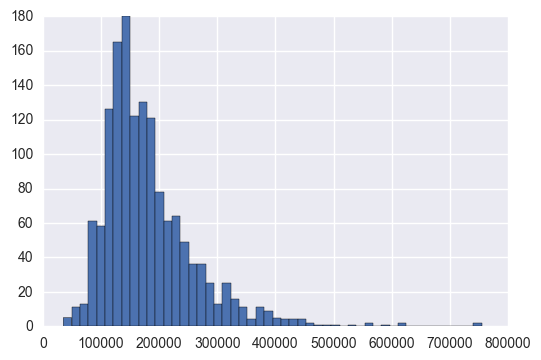

In [8]:
# SalePrice Distribution
train['SalePrice'].describe()
#histogram
plt.hist(train['SalePrice'],bins=50)
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [9]:
#applying log transformation
train['SalePrice'] = np.log(train['SalePrice'])

Skewness: 0.121335
Kurtosis: 0.809532


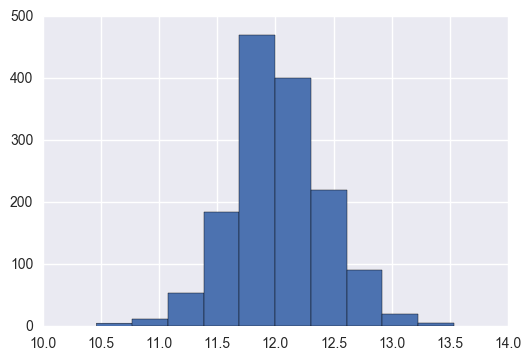

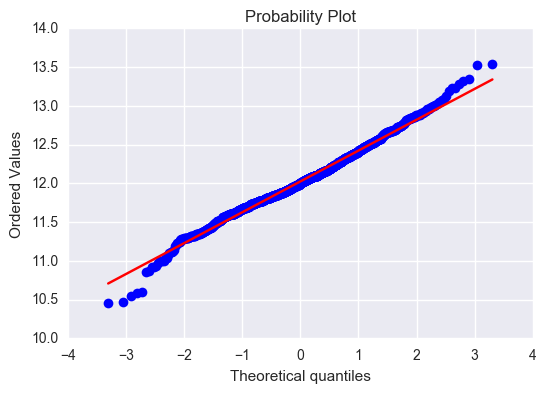

In [5]:
#transformed histogram and normal probability plot
plt.hist(train['SalePrice']);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [4]:
# Duplicates
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("there are " + str(idsDupli) + " duplicates for the " + str(idsTotal) + " rows")

there are 0 duplicates for the 1460 rows


In [10]:
# create categorical and non-categorical columns
train=train.drop("Id", 1)
all_columns = train.columns.values
non_categorical = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", 
                   "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
                   "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", 
                   "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
                   "ScreenPorch","PoolArea", "MiscVal"]

categorical = [value for value in all_columns if value not in non_categorical]
del categorical[-1] #Supprimer SalePrice

dataquanti=train[non_categorical]
dataquali=train[categorical]

In [44]:
# IQR for outliers
def isoutliers(col):
    Q1=np.percentile(col, 25)
    Q3=np.percentile(col, 75)
    IQR=Q3-Q1
    for i in range(1,col.shape[0]):
        if (col[i]< Q1-1.5*IQR or col[i]>Q3+1.5*IQR) and col[i]!=0:
            print(i,col[i])
    print(Q1-1.5*IQR,Q3+1.5*IQR)        

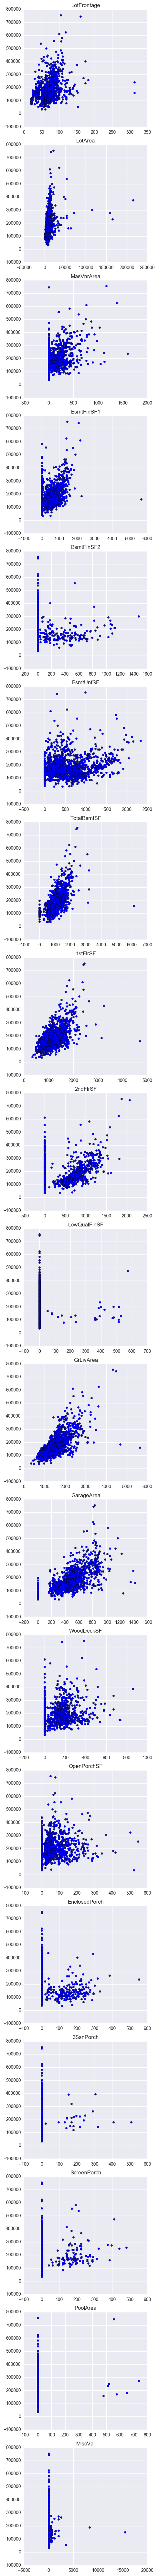

In [7]:
# Outliers
plt.figure(1)
f, axarr = plt.subplots(dataquanti.shape[1], figsize=(5, 80))
price = train.SalePrice
for col in range(dataquanti.shape[1]):
    axarr[col].scatter(dataquanti.iloc[:,col],price)
    axarr[col].set_title(dataquanti.columns[col])
plt.tight_layout()
plt.show()
    

In [11]:
# Remove few outliers
print("Dim with outliers",train.shape)

#Remove BsmtFinSF1 > 5000
train=train[train.BsmtFinSF1<5000]
#Remove TotalBsmtSF > 6000
train=train[train.TotalBsmtSF<6000]
#Remove LowQualFinSF > 550 
train=train[train.LowQualFinSF<550]
# Remove GrvLivArea > 4000
train=train[train.GrLivArea<4000]
# Remove GarageArea > 1300
train=train[train.GarageArea<1300]
# Remove OpenPorsh >500
train=train[train.OpenPorchSF<500]
# Remove SalePrice > 700000
train=train[train.SalePrice<700000]

print("Dim without outliers",train.shape)


Dim with outliers (1460, 80)
Dim without outliers (1450, 80)


### Merge train and test

In [13]:
#import test
test=pd.read_csv('test.csv')
test.shape

(1459, 80)

In [14]:
data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

In [9]:
# Deal with missing values

allquanti=data[non_categorical]
allquali=data[categorical]

# NaN non_categorical :
count_nan_quanti=len(data[non_categorical])-data[non_categorical].count()
print(count_nan_quanti[count_nan_quanti!=0])

data.LotFrontage[np.isnan(data.LotFrontage)]=0
data[non_categorical] = data[non_categorical].fillna(data[non_categorical].mean())

count_nan_quanti=len(data[non_categorical])-data[non_categorical].count()
print(count_nan_quanti[count_nan_quanti!=0])

# NaN categorical : 

# fill Na by info when it is necessary
data[categorical] = data[categorical].fillna("info")

LotFrontage    485
MasVnrArea      23
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
GarageArea       1
dtype: int64
Series([], dtype: int64)


C:\Users\bmelloul\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
# standardize our Data
from sklearn.preprocessing import StandardScaler
data[non_categorical] = StandardScaler().fit_transform(data[non_categorical])

In [12]:
# Transformer les variables en binaires
data=pd.get_dummies(data)

In [13]:
data.shape

(2909, 426)

## Feature Selction

In [14]:
#Split Training/Test
X=data[:train.shape[0]]
X_submit = data[train.shape[0]:]
y=train.SalePrice

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
BoostingSelect=GradientBoostingRegressor(n_estimators=1000,random_state=11)
BoostingSelect.fit(X, y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=11, subsample=1.0, verbose=0,
             warm_start=False)

In [17]:
# Let's have a look at the importance of each feature.
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = BoostingSelect.feature_importances_
features.sort(['importance'],ascending=False)

C:\Users\bmelloul\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
15,GrLivArea,0.060350
10,BsmtUnfSF,0.046625
2,LotArea,0.042050
22,GarageArea,0.032841
11,TotalBsmtSF,0.032095
30,MoSold,0.030105
8,BsmtFinSF1,0.028380
12,1stFlrSF,0.026992
3,OverallQual,0.025637
5,YearBuilt,0.023185


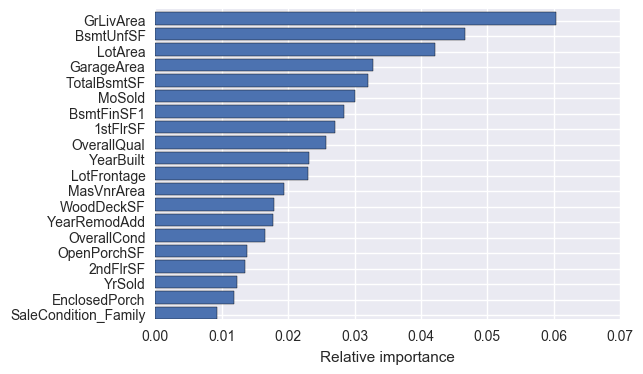

In [17]:
# Feature Imp selon Boosting:
# sort importances
indices = np.argsort(BoostingSelect.feature_importances_)
indimp_bst=indices[len(indices)-20:] # 20 most important feature : take the end of indice array 
plt.barh(np.arange(len(X[indimp_bst].columns)), BoostingSelect.feature_importances_[indimp_bst])
plt.yticks(np.arange(len(X[indimp_bst].columns))+0.25 , np.array(X.columns)[indimp_bst],fontsize=10)
_ = plt.xlabel('Relative importance')

In [18]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(BoostingSelect, prefit=True)
train_new = model.transform(X)
train_new.shape

(1450, 81)

In [19]:
test_new = model.transform(X_submit)
test_new.shape

(1459, 81)

## 2. Modeling

####  RMSLE

In [20]:
# Roor Mean Squared Logarithmic Error : RMSLE
from sklearn.metrics import mean_squared_error
def rmsle(y, y_prediction):
    return np.sqrt(mean_squared_error(y,y_prediction))

#### Split Training/Test

In [21]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_new, y, random_state=1,test_size=0.15)

### Model 1 : RL

In [22]:
# import model
from sklearn.linear_model import LinearRegression
# instantiate
linreg = LinearRegression()
# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)
# make predictions on the testing set
y_pred = linreg.predict(X_test)
from sklearn import metrics
# calculate RMSE using scikit-learn
print("RMSLE RL:",rmsle(y_test,y_pred))

RMSLE RL: 0.115759500235


### Model 2 : CART

In [20]:
from sklearn.tree import DecisionTreeRegressor
tree=DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_tree=tree.predict(X_test)
# calculate RMSE using scikit-learn
print("RMSLE CART:",rmsle(y_test,y_pred_tree))


RMSLE CART: 0.192843618029


### Model 3 : RF

In [22]:
from sklearn.grid_search import GridSearchCV 

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
from sklearn.ensemble import RandomForestRegressor
Gridrf=GridSearchCV(RandomForestRegressor(),
                {'n_estimators':[100,500,1000,1300,1500,1800,2000],'max_features':[20,25,30]},cv=5,scoring='mean_squared_error')
Gridrf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500, 1000, 1300, 1500, 1800, 2000], 'max_features': [20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [24]:
print(Gridrf.best_params_)

{'n_estimators': 1500, 'max_features': 20}


In [21]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1500,max_features=20,bootstrap=True,oob_score=True,random_state=11)
rf.fit(X_train, y_train)
y_pred_rf=rf.predict(X_test)
print("RMSLE RF:",rmsle(y_test,y_pred_rf))

RMSLE RF: 0.106565747466


### Model 4 : Boosting

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

In [38]:
paramgrid_bst={'learning_rate':[0.05,0.02,0.01],
               'max_features': [20,25,30],
               'max_depth':[2,3,4,5],
               'min_samples_leaf':list(range(2,7,2))}
GridBoosting=GridSearchCV(GradientBoostingRegressor(n_estimators=1000),paramgrid_bst,cv=5,n_jobs=3,scoring='mean_squared_error')
GridBoosting.fit(X_train, y_train)
print(GridBoosting.best_params_)

{'max_depth': 2, 'learning_rate': 0.05, 'max_features': 20, 'min_samples_leaf': 4}


In [29]:
gb2= GradientBoostingRegressor(n_estimators=1000, min_samples_leaf= 4, max_depth= 2, max_features= 20,learning_rate= 0.05,random_state=11)
gb2.fit(X_train, y_train)
y_pred_gb2=gb2.predict(X_test)
print("RMSLE GB2:",rmsle(y_test,y_pred_gb2))

RMSLE GB2: 0.103692056813


### Model 5 : SVM

In [41]:
from sklearn.svm import SVR
svc = SVR()
C_range = list(np.logspace(0,1,10))
gamma_range = list(np.logspace(-5,-1,20))
paramgrid_svm = dict(gamma=gamma_range, C=C_range)
GridSVM = GridSearchCV(SVR(), param_grid=paramgrid_svm, cv=5,scoring='mean_squared_error')
GridSVM.fit(X_train, y_train)
print(GridSVM.best_params_)

{'gamma': 0.00018329807108324357, 'C': 10.0}


In [42]:
svc=SVR(C=10,gamma=0.00018329807108324357)
svc.fit(X_train,y_train)
y_pred_svm = svc.predict(X_test)
print("RMSLE SVM:",rmsle(y_test,y_pred_svm))

RMSLE SVM: 0.100332095838


----

### Model 6 : XGBoost

In [27]:
import xgboost as xgb

In [28]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

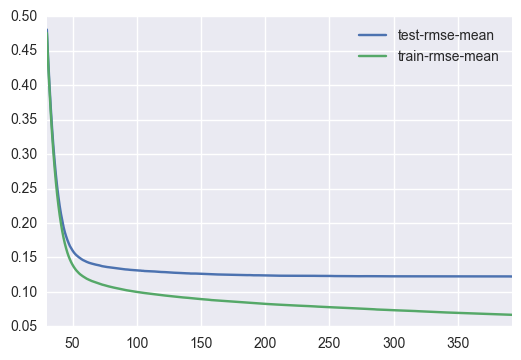

In [29]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [30]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [32]:
y_pred_xgb=model_xgb.predict(X_test)
print("RMSLE XGB:",rmsle(y_test,y_pred_xgb))

RMSLE XGB: 0.120109361422
